In [6]:
%pylab inline
!pip install natsort

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from natsort import natsorted
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.manual_seed(1)

Populating the interactive namespace from numpy and matplotlib


In [30]:
BS = 3
LAMBDA = 1

In [31]:
std_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
])

style_ds = torchvision.datasets.ImageFolder(root ='/content/for_class', transform = std_transform)
style_loader = torch.utils.data.DataLoader(style_ds, batch_size=BS, shuffle = True, drop_last = True)

Imgs loaded


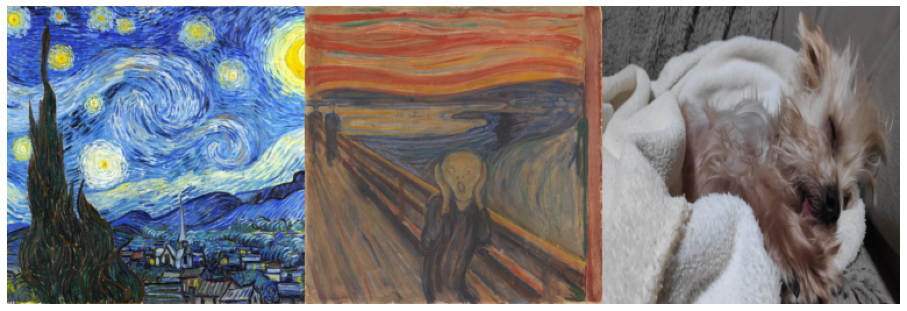

In [43]:
def concat_img(imgs):
    figsize(16,16)
    figure()
    #imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()

imgs, _ = next(iter(style_loader))
print("Imgs loaded")
concat_img(imgs[:3])

In [44]:
class VGG_Encoder(torch.nn.Module):
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        pretrained = torchvision.models.vgg19(pretrained=True)
        
        f = torch.nn.Sequential(*list(pretrained.features.children())[:21]).eval()
        
        # Splitting the network so we can get output of different layers
        # TODO: ADD REFLECTION PADDING LAYERS
        self.relu1_1 = torch.nn.Sequential(*f[:2],)
        self.relu2_1 = torch.nn.Sequential(*f[2:5], *f[5:7])
        self.relu3_1 = torch.nn.Sequential(*f[7:10],*f[10:12])
        self.relu4_1 = torch.nn.Sequential(*f[12:14],
                                          *f[14:16],
                                          *f[16:19],
                                           *f[19:21])

    def forward(self, x):
        out_1 = self.relu1_1(x)
        out_2 = self.relu2_1(out_1)
        out_3 = self.relu3_1(out_2)
        result = self.relu4_1(out_3)
        return out_1, out_2, out_3, result

def mean_and_std(x):
    x = x.view(x.shape[0], x.shape[1], -1)
    mean = x.mean(dim=2) + 0.00005
    std = x.var(dim=2).sqrt()
    return mean.view(mean.shape[0], mean.shape[1], 1, 1), std.view(std.shape[0], std.shape[1], 1, 1)

class AdaIN(torch.nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
        self.IN = torch.nn.InstanceNorm2d(512)
    
    def forward(self, x, y):
        size = x.size()
        
        x = self.IN(x)
        
        #mean_x, std_x = mean_and_std(x)
        mean_y, std_y = mean_and_std(y)
        #x = (x - mean_x.expand(size)) / std_x.expand(size)
        x = x * std_y.expand(size) + mean_y.expand(size)
        return x
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = torch.nn.Sequential(
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(512, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 256, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(256, 128, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(128, 128, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(128, 64, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(64, 64, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d((1, 1, 1, 1)),
            torch.nn.Conv2d(64, 3, (3, 3)),
        )
    def forward(self, x):
        result = self.decode(x)
        return result

class Style_Transfer_Network(torch.nn.Module):
    def __init__(self):
        super(Style_Transfer_Network, self).__init__()
        self.encoder = VGG_Encoder()
        self.adain = AdaIN()
        self.decoder = Decoder()
        
    def forward(self, content, style):
        out1, out2, out3, result_content = self.encoder(content)
        #encoded_content = [out1, out2, out3, result_content]
        
        out1, out2, out3, result_style = self.encoder(style)
        encoded_style = [out1, out2, out3, result_style]
        
        t = self.adain(result_content, result_style)
        t = LAMBDA * t + (1 - LAMBDA) * result_content
        
        img = self.decoder(t)
        
        out1, out2, out3, result_img = self.encoder(img)
        encoded_img = [out1, out2, out3, result_img]
        
        return t, encoded_style, encoded_img, img

In [45]:
Style_Network = Style_Transfer_Network().cuda()


PATH = '/content/style_net_v2'
checkpoint = torch.load(PATH)
Style_Network.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


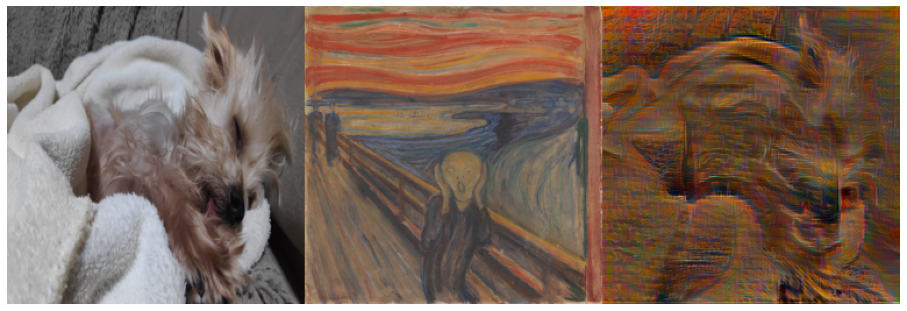

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


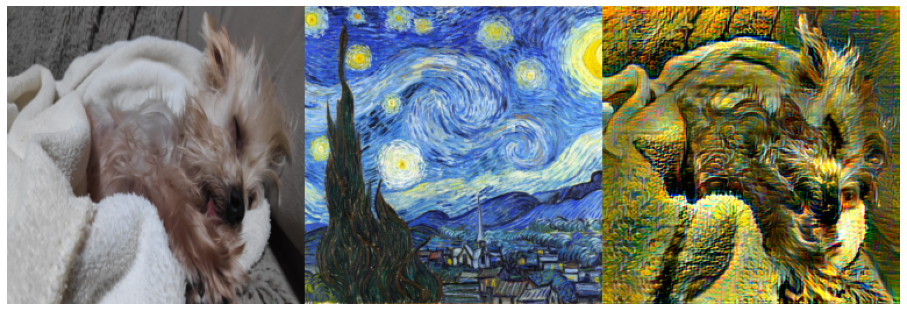

In [54]:
def print_img(content, style, output):
    printable = torch.cat((content.cpu(), style.cpu(), output.cpu()), 0)
    concat_img((printable).detach().cpu())

#style, _ = next(iter(style_loader))
style_n = 1
content_n = 3
LAMBDA = 2
_, _, _, img1 = Style_Network(style[1].view(1, 3, 256, 256).cuda(),style[2].view(1, 3, 256, 256).cuda())
_, _, _, img2 = Style_Network(style[1].view(1, 3, 256, 256).cuda(),style[0].view(1, 3, 256, 256).cuda())
print_img(style[1].view(1, 3, 256, 256), style[2].view(1, 3, 256, 256), img1)
print_img(style[1].view(1, 3, 256, 256), style[0].view(1, 3, 256, 256), img2)